# Warm Up - Grid Search

#### Because everyone loves exhaustively searching parameter spaces

So far we have not done any hyperparameter tuning yet, so we will do some now with sklearn's GridSearch functionality

## Dependencies

same as before but now we are also bringing in `GridSearch`

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

sns.set_palette(sns.color_palette("bright", 8))

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

Load the dataset

In [3]:

features, labels = sklearn.datasets.load_breast_cancer(return_X_y=True)

Setup our train function, which is now called `tune`

We are still doing KFold CV here but notice that we have lost the loop! `GridSearchCV` is now in charge of looping and scheduling our runs

In [4]:
def tune(X, y,         # Our data as before 
         param_grid,   # Our search parameters
         cv=None,      # A CV strategy of our choice
         n_jobs=None): # number of parallel jobs 

    # as before except not parameterised
    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(
                random_state=42 # we only set the random state!
            )
        )
    
    grid_search = GridSearchCV(pipeline,
                           param_grid,
                           scoring='f1_micro',
                           cv=cv,
                           n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

Previously we used 
```
pipeline = make_pipeline(RobustScaler(),
                          RandomForestClassifier(
                              n_estimators=15,
                              criterion="entropy",
                              max_features="auto",
                              bootstrap=True,
                              random_state=42))
```

## time to search

In [5]:
from pprint import pprint
import time

# setup a parameter grid, other possible params
#
# criterion              {“gini”, “entropy”}, default=”gini”
# max_depth              int, default=None
# min_samples_leaf       int or float, default=1
# max_features           “auto”, “sqrt”, “log2”}, int or float, default=”auto”
# bootstrap              bool, default=True
#
param_grid = {
  'randomforestclassifier__n_estimators': [1,5,15,50,100]
}


# run the grid search
tic = time.perf_counter()
results, best_index = tune(features,
                           labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=3)
toc = time.perf_counter()



def print_some_facts(results, best_index, tic, toc):
    print("K Fold Tuning Results")
    print(f"Elapsed Time {toc - tic:0.4f} seconds")
    print("Best Index", best_index)
    print("Best Param Set:")
    pprint(results["params"][best_index])
    print(f"F1 Score {results['mean_test_score'][best_index]:.4f} +/- {results['std_test_score'][best_index]}")
    
print_some_facts(results, best_index, tic, toc)

K Fold Tuning Results
Elapsed Time 2.3668 seconds
Best Index 4
Best Param Set:
{'randomforestclassifier__n_estimators': 100}
F1 Score 0.9561 +/- 0.02283883380490945


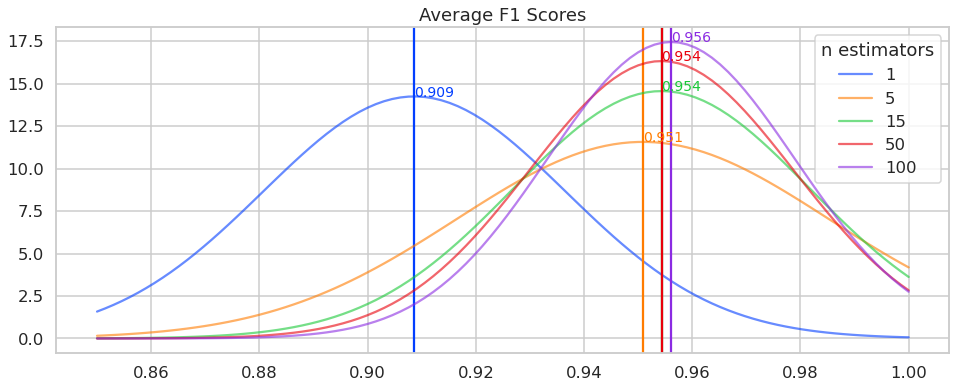

In [6]:
from scipy.stats import norm

def plot_some_results(results):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    mu = results['mean_test_score']
    sigma = results['std_test_score']
    n_estimators = [p["randomforestclassifier__n_estimators"] for p in results["params"]]

    lines = []
    for mu, sigma in zip(results['mean_test_score'], results['std_test_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_results(results)

## Increase the size of the search space

In [7]:
#
# 3D search space - 30 combinations - 150 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=10)
toc = time.perf_counter()

In [7]:
# Take top N models
def take_n_best(x, n):
    idxs = [xx-1 for xx in x["rank_test_score"][:n]]
    y = { k:np.array(v)[idxs] for k,v in x.items() }
    y["rank_test_score"] = list(range(0, len(idxs)))
    return y, 0

In [8]:
from pprint import pprint
pprint(results["params"][best_index])

{'randomforestclassifier__n_estimators': 100}


K Fold Tuning Results
Elapsed Time 4.5296 seconds
Best Index 19
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9701 +/- 0.011885446954182715


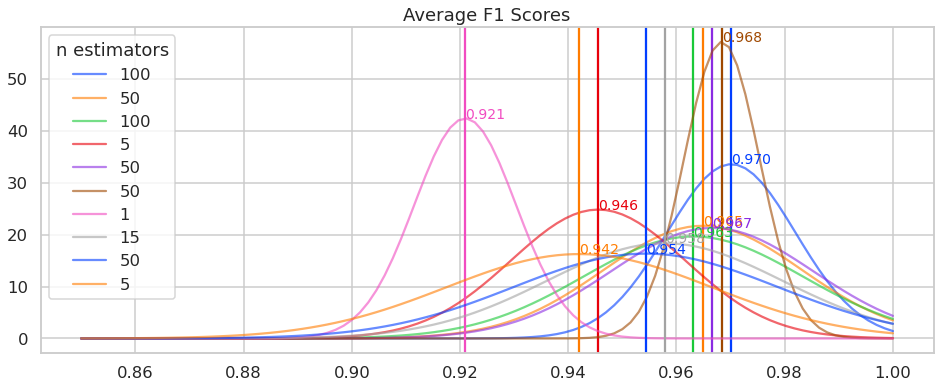

In [10]:
print_some_facts(results, best_index, tic, toc)

top_results, best_index = take_n_best(results, 10)

plot_some_results(top_results)

## Really increase the size of the search space

In [11]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': [1,2,3,4],
    'randomforestclassifier__min_samples_split': [3,4,5,6] 
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=10)
toc = time.perf_counter()

K Fold Tuning Results
Elapsed Time 92.9029 seconds
Best Index 724
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9754 +/- 0.012875287888421138


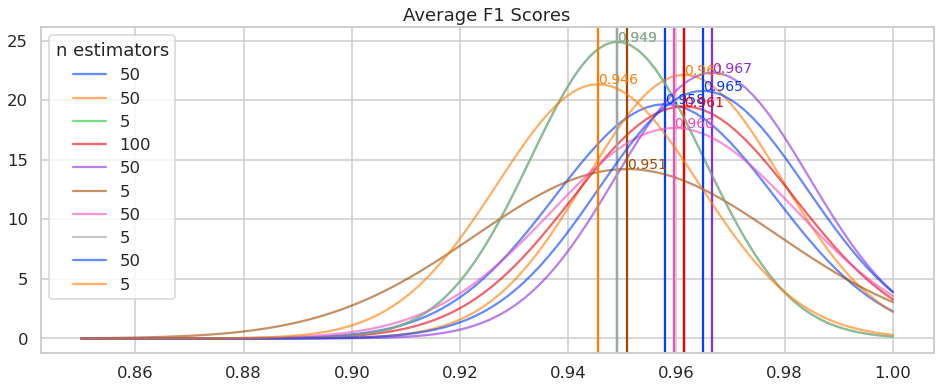

In [12]:
print_some_facts(results, best_index, tic, toc)

top_results, best_index = take_n_best(results, 10)

plot_some_results(top_results)

## Go Random Go!

A better way to search over a large space is to use a different Random Search strategy, and save grid search to fine tune after you are in the ballpark, if you need it

Can we find the same hyperparameter combination fast with random search?

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
def rand_tune(X, y, param_dist, n_iter=10,
             cv=None,
             n_jobs=None):

    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(random_state=42)
        )
    
    
    #
    # Same as before, except now we use the RandomizedSearchCV
    #
    grid_search = RandomizedSearchCV(pipeline,
                                   param_dist,
                                   n_iter=n_iter,
                                   scoring='f1_micro',
                                   cv=cv,
                                   n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

In [12]:
import scipy.stats as stats

param_dist = {
    'randomforestclassifier__n_estimators': stats.randint(1,200),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': stats.randint(1,5),
    'randomforestclassifier__min_samples_split': stats.randint(3,6) 
}

In [15]:
tic = time.perf_counter()
results, best_index = rand_tune(features,
                                labels,
                                param_dist,
                                
                                #
                                # Here we set the number of random samples we are attempting
                                #
                                n_iter=100,
                                
                                cv=StratifiedKFold(n_splits=5),
                                n_jobs=10)
toc = time.perf_counter()

K Fold Tuning Results
Elapsed Time 26.5108 seconds
Best Index 0
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 95}
F1 Score 0.9684 +/- 0.01887233903501267


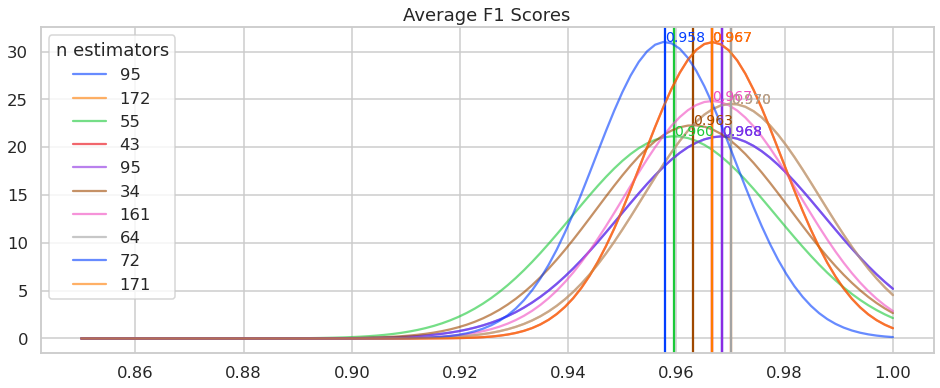

In [14]:
top_results, best_index = take_n_best(results, 10)

print_some_facts(top_results, best_index, tic, toc)
plot_some_results(top_results)

## Compare results

### Really large search space results

K Fold Tuning Results
Elapsed Time 92.9029 seconds
Best Index 724
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9754 +/- 0.012875287888421138

### Random search results

K Fold Tuning Results
Elapsed Time 26.5108 seconds
Best Index 0
Best Param Set:
{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 95}
F1 Score 0.9684 +/- 0.01887233903501267

## Takeaway
 
 - Looked at a couple of search strategies
 - We have seen the amount of ccompute scaling even with this simple problem